# Part 1, Write the wavenet

In [2]:
import torch
import torchaudio
import random
import numpy
import optuna

#Pytorch does not have dilated causal convolutions available
#So, we must implement one from scratch
class DilatedCausalConvolution(torch.nn.Conv1d):
    def __init__(self, in_channels, out_channels, kernel_size, dilation=1):
        self.dilation = dilation
        self.pad = dilation * (kernel_size - 1) 
        self.kernel_size = kernel_size
        super(DilatedCausalConvolution, self).__init__(in_channels,out_channels,padding=self.pad,kernel_size=kernel_size,dilation=dilation)

    def forward(self, input):
        result = super(DilatedCausalConvolution, self).forward(input) 
        #Don't pad the result if the kernel size is 1 or theres no dilation
        return result if self.kernel_size[0] == 1 or self.dilation[0] == 0 else result[:, :, : -self.pad]
        #Otherwise we pad it on the left so that no neurons can influence neurons to the right of it on the layer above it.
        #which creates a sort of casual relationship

class Wavenet(torch.nn.Module):
    def __init__(self, depth, num_stacks, kernel_size):
        super(Wavenet, self).__init__()
    
        self.input_layer = DilatedCausalConvolution(1, 1, 1)

        #Creates several stacks of dilated causal convolutional layers
        #When the depth is greater, neurons on the top layer will be influenced by
        #neurons on the bottom layer that are further to the left, allowing the model to
        #take longer-term patterns into consideration
        causal_convolutional_layers = []
        for i in range(num_stacks):
            for j in range(depth):
                causal_convolutional_layers.append(DilatedCausalConvolution(1, 2, kernel_size, 2**j))
                
        self.causal_convolutional_layers = torch.nn.ModuleList(causal_convolutional_layers)

        self.conv1d= torch.nn.Conv1d(depth * num_stacks, out_channels=1, kernel_size=1)

    def forward(self, x):

        output = torch.clone(x)

        skip_connections = []
        output = self.input_layer(x)
        for i in range(len(self.causal_convolutional_layers)):
            layer_result = self.causal_convolutional_layers[i](output)

            #The weird activation functon from the Wavenet paper. 
            output = torch.tanh(torch.split(layer_result, 1, dim=1)[0]) * torch.sigmoid(torch.split(layer_result, 1, dim=1)[1])

            skip_connections.append(output)

            output = output + output[:, :, -output.size(2) :]
            

        output = torch.cat([s[:, :, -output.size(2) :] for s in skip_connections], dim=1)
        output = self.conv1d(output)


        return output
    
model = Wavenet(7, 5, 2)
    

# Part 2, prepare the datasets

In [3]:
normal_paths = open("test_normal_paths.txt", "r")
anomaly_paths = open("test_anomaly_paths.txt", "r")

normal_train_X = []

anomaly_test_X = []

i=0
for line in normal_paths.readlines():
    waveform, sample_rate = torchaudio.load("./data/test_normal/" + line[:-1], normalize=True)
    transform = torchaudio.transforms.MuLawEncoding(quantization_channels=256)
    mulawtrans = transform(waveform)
    l = mulawtrans[0].tolist()
    l = l[0::2]
    normal_train_X.append([v/10 for v in l] )
    i += 1
    if i > 1000:
        break
    


In [4]:
i=0
for line in anomaly_paths.readlines():
    waveform, sample_rate = torchaudio.load("./data/test_anomaly/" + line[:-1], normalize=True)
    transform = torchaudio.transforms.MuLawEncoding(quantization_channels=256)
    mulawtrans = transform(waveform)
    l = mulawtrans[0].tolist()
    l = l[0::2]
    anomaly_test_X.append([v/10 for v in l] )
    i += 1
    if i > 100:
        break


#So, we're gonna say that if the MSE between the prediction and the output is above a certain
#threshold, then the sample is "anomalous". The wavenet paper predicts individual segments of audio
#that are anomalous and marks them as such, but in this assignment we appear to just need to classify
#the entire wav file as anomalous/non-anomalous.


# Part 3, Train the model and optimize hyperparameters

So, for this one, the number of stacks and the depth of each stack of dilated causal convolutions are hyperparamters. The kernel size of the convolutions is also a hyperparameter. I also have a threshold value as a hyperparameter. If the MSE of the prediction is above this threshold, the sample is counted as anomalous. I will optimize this hyperparameter with optuna after training the wavenet. I will optimize the number of stacks and depth and the threshold with optuna.

In [15]:
def optimize_wavenet(trial):
    num_stacks = trial.suggest_int("num_stacks", 1, 10)
    depth = trial.suggest_int("depth", 1, 5)
    model = Wavenet(num_stacks, depth, 2)
    adam = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_function = torch.nn.MSELoss()

    for epoch in range(100):
        wave = torch.Tensor(random.choice(normal_train_X))
        wave = torch.reshape(wave, [1, 1, 88000])
        output = model(wave)
        loss = loss_function(output, wave)
        loss.backward()

        adam.step()
        adam.zero_grad()
    return loss.item()

study = optuna.create_study(direction="minimize")
study.optimize(optimize_wavenet, n_trials=10)

best_num_stacks = study.best_params["num_stacks"]
best_depth = study.best_params["depth"]

[I 2023-12-03 19:01:07,617] A new study created in memory with name: no-name-7ddf2668-3dca-49ed-80fc-4f9c3d2d196c
[I 2023-12-03 19:01:09,441] Trial 0 finished with value: 163.28924560546875 and parameters: {'num_stacks': 8, 'depth': 1}. Best is trial 0 with value: 163.28924560546875.
[I 2023-12-03 19:01:12,622] Trial 1 finished with value: 167.70022583007812 and parameters: {'num_stacks': 3, 'depth': 5}. Best is trial 0 with value: 163.28924560546875.
[I 2023-12-03 19:01:13,903] Trial 2 finished with value: 174.52450561523438 and parameters: {'num_stacks': 2, 'depth': 2}. Best is trial 0 with value: 163.28924560546875.
[I 2023-12-03 19:01:14,912] Trial 3 finished with value: 173.19615173339844 and parameters: {'num_stacks': 3, 'depth': 1}. Best is trial 0 with value: 163.28924560546875.
[I 2023-12-03 19:01:17,231] Trial 4 finished with value: 173.40066528320312 and parameters: {'num_stacks': 10, 'depth': 1}. Best is trial 0 with value: 163.28924560546875.
[I 2023-12-03 19:01:19,677] Tr

In [16]:
model = Wavenet(best_num_stacks, best_depth, 2)
adam = torch.optim.Adam(model.parameters(), lr=0.0005)
loss_function = torch.nn.MSELoss()


loss_Y = []
for epoch in range(8000):
    wave = torch.Tensor(random.choice(normal_train_X))
    wave = torch.reshape(wave, [1, 1, 88000])
    output = model(wave)
    loss = loss_function(output, wave)
    loss.backward()

    adam.step()
    adam.zero_grad()
    
    loss_Y.append(loss.item())

torch.save(model.state_dict(), "./model.p")

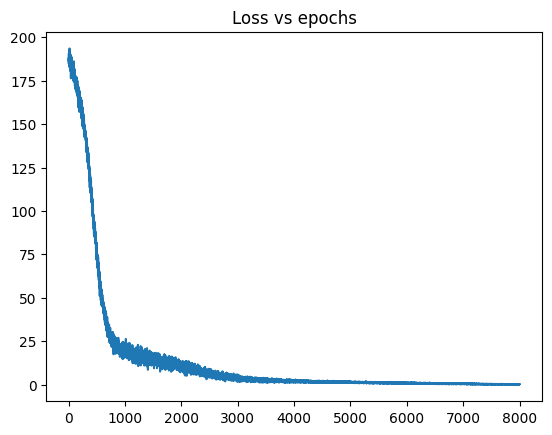

In [17]:
from matplotlib import pyplot as plt

plt.plot([i for i in range(len(loss_Y))], loss_Y)
plt.title("Loss vs epochs")
plt.show()

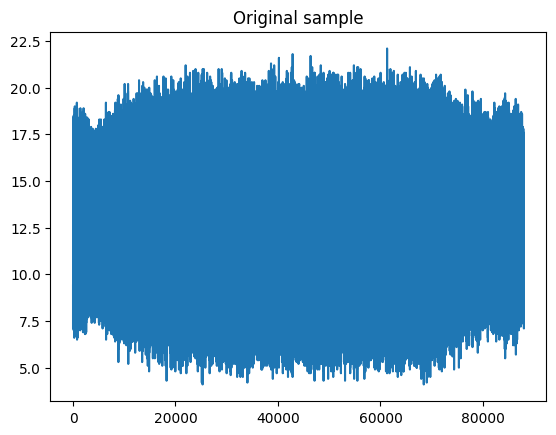

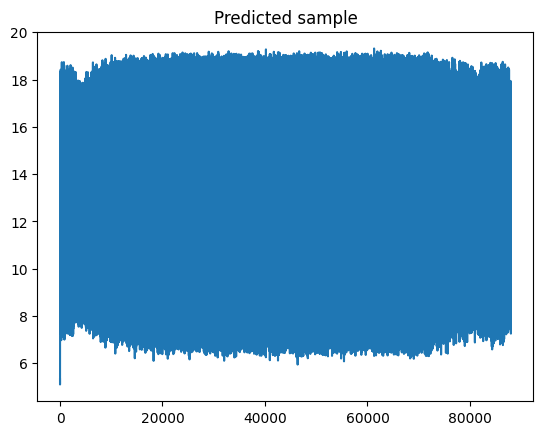

In [18]:
sample_x = random.choice(normal_train_X)
wave = torch.Tensor(sample_x)
wave = torch.reshape(wave, [1, 1, 88000])
output = torch.flatten(model(wave)).tolist()

plt.title("Original sample")
plt.plot([i for i in range(len(sample_x))], sample_x)
plt.show()
plt.title("Predicted sample")
plt.plot([i for i in range(len(sample_x))], output)
plt.show()

In [19]:
#So, we're gonna say that if the error between the prediction and the output is above a certain
#threshold, then the sample is "anomalous". The wavenet paper predicts individual segments of audio
#that are anomalous and marks them as such, but in this assignment we appear to just need to classify
#the entire wav file as anomalous/non-anomalous.

from sklearn.metrics import f1_score

def error(x, y):
    sum = 0
    for i in range(len(x)):
        sum += (x[i] - y[i])**2
    return sum
def objective(trial):
    threshold = trial.suggest_float("threshold", 0, 10)
    actuals = []
    predicteds = []
    for i in range(50):
        if(random.random() > 0.5):
            actuals.append(False)
            sample_x = random.choice(normal_train_X)
        else:
            actuals.append(True)
            sample_x = random.choice(anomaly_test_X)

        wave = torch.Tensor(sample_x)
        wave = torch.reshape(wave, [1, 1, 88000])
        output = torch.flatten(model(wave)).tolist()
        err = error(output, sample_x)
        if err > threshold:
            predicteds.append(True)
        else:
            predicteds.append(False)
    
    return f1_score(actuals, predicteds)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)



[I 2023-12-03 19:14:14,827] A new study created in memory with name: no-name-1ce29c21-e480-4c5c-874f-099b91aed049
[I 2023-12-03 19:14:16,235] Trial 0 finished with value: 0.7341772151898733 and parameters: {'threshold': 3.16542569721451}. Best is trial 0 with value: 0.7341772151898733.
[I 2023-12-03 19:14:17,620] Trial 1 finished with value: 0.6842105263157895 and parameters: {'threshold': 7.03466895826312}. Best is trial 0 with value: 0.7341772151898733.
[I 2023-12-03 19:14:19,093] Trial 2 finished with value: 0.5714285714285715 and parameters: {'threshold': 6.982565226491878}. Best is trial 0 with value: 0.7341772151898733.
[I 2023-12-03 19:14:20,415] Trial 3 finished with value: 0.7012987012987013 and parameters: {'threshold': 3.7831405508610128}. Best is trial 0 with value: 0.7341772151898733.
[I 2023-12-03 19:14:21,754] Trial 4 finished with value: 0.7951807228915663 and parameters: {'threshold': 9.783579459806385}. Best is trial 4 with value: 0.7951807228915663.
[I 2023-12-03 19:

# So, as we can see, the best trial was with the threshold set to 2.8953, giving as an f1 score of 0.8095, which isn't bad.